# There is a hidden problem in the calculations. 
# The Notebook runs fine, but the results are wrong.
The first clue is that the break even for all regions is negative. 


# Sprint 9. Machine Learning in Business
## Project description
You work for the OilyGiant mining company. Your task is to find the best place for a new well.
Steps to choose the location:
* Collect the oil well parameters in the selected region: oil quality and volume of reserves;
* Build a model for predicting the volume of reserves in the new wells;
* Pick the oil wells with the highest estimated values;
* Pick the region with the highest total profit for the selected oil wells.
You have data on oil samples from three regions. Parameters of each oil well in the region are already known. Build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the Bootstrapping technique.
## Data description
Geological exploration data for the three regions are stored in files:
* geo_data_0.csv. download dataset
* geo_data_1.csv. download dataset
* geo_data_2.csv. download dataset
* id — unique oil well identifier
* f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
* product — volume of reserves in the oil well (thousand barrels).
## Conditions:
* Only linear regression is suitable for model training (the rest are not sufficiently predictable).
* When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
* The budget for development of 200 oil wells is 100 USD million.
* One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
* After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

# 1. Download and prepare the data. 
Explain the procedure.

In [67]:
# Load libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

## 1.2  Load the Data
This function downloads the datasets, saves them in a local 'datasets' folder, and loads them into pandas DataFrames.

In [68]:
import os
import pandas as pd

def download_and_load_datasets():
    # Check if the datasets folder exists
    if not os.path.exists('datasets'):
        os.makedirs('datasets')

    # Download the source CSV files and save them in the datasets folder
    urls = [
        'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_0.csv',
        'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_1.csv',
        'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_2.csv'
    ]
    filenames = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
    
    data = []

    for url, filename in zip(urls, filenames):
        try:
            df = pd.read_csv(url)
        except:
            df = pd.read_csv(url)
        
        df.to_csv(f'datasets/{filename}')
        data.append(df)
    
    return data

data = download_and_load_datasets()


# 2. Train and test the model for each region

This code saves the average predicted volumes and RMSE values for each region in separate lists, so you can easily use them later in the analysis without hardcoding the values. <br>
2.3 It also creates a dictionary called region_result for each region and stores the predictions and correct answers in it. These dictionaries are then appended to the region_results list, which will contain the results for all regions.

In [69]:
region_averages = []
region_rmse = []
targets_valid = []
predictions_list = []

for i, region in enumerate(data):
    # 2.1. Split the data into a training set and validation set at a ratio of 75:25
    features = region.drop(['id', 'product'], axis=1)
    target = region['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

    # # 2.2. Train the model and make predictions for the validation set
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    # 2.3. Save the predictions and correct answers for the validation set
    targets_valid.append(target_valid)
    predictions_list.append(pd.Series(predictions, index=target_valid.index))

    # 2.4. Calculate the average volume of predicted reserves and model RMSE
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    avg_predicted_volume = predictions.mean()

    # Save region averages and RMSE to their respective lists
    region_averages.append(avg_predicted_volume)
    region_rmse.append(rmse)

    print(f"Region {i}: Average predicted volume: {avg_predicted_volume}, RMSE: {rmse}")




Region 0: Average predicted volume: 92.59256778438035, RMSE: 37.5794217150813
Region 1: Average predicted volume: 68.728546895446, RMSE: 0.8930992867756182
Region 2: Average predicted volume: 94.96504596800489, RMSE: 40.02970873393434


## 2.5 Analyze the results
### Discuss the model performance for each region
| Region | Average Predicted Volume (thousand barrels) | RMSE   |
|--------|---------------------------------------------|--------|
| 0      | 92.5925                                    | 37.5794|
| 1      | 68.7285                                    | 0.8931 |
| 2      | 94.9650                                    | 40.0297|


From these results, we can observe that the average predicted volumes of oil reserves for Region 0 and Region 2 are higher than that of Region 1. However, the RMSE is also significantly higher for both Region 0 and Region 2, indicating that the model's predictions have a larger margin of error in these regions.

On the other hand, the RMSE for Region 1 is very low, which implies that the model's predictions are more accurate for this region. This could be beneficial when making decisions about which wells to develop, as there is a higher level of certainty in the predicted oil reserves.

In the next sections, we will calculate the potential profit and risk for each region, which will help us to make a better-informed decision about which region to select for oil well development.

# 3. Prepare for profit calculation

## 3.1. Store all key values for calculations in separate variables

In [70]:
# 3.1. Store all key values for calculations in separate variables
BUDGET = 100_000_000
REVENUE_PER_THOUSAND_BARRELS = 4_500
WELLS_FOR_DEVELOPMENT = 200


## 3.2. Calculate the volume of reserves sufficient for developing a new well without losses. 
Compare the obtained value with the average volume of reserves in each region.
This code will print the break-even volume and the average predicted volume for each region, and indicate whether the average predicted volume is above or below the break-even volume.

In [71]:
break_even_volume = BUDGET / (WELLS_FOR_DEVELOPMENT * REVENUE_PER_THOUSAND_BARRELS)
print("Break-even volume (thousand barrels):", break_even_volume)


Break-even volume (thousand barrels): 111.11111111111111


## 3.3. Provide the findings about the preparation for profit calculation step


In [72]:
# 3.3. Provide the findings about the preparation for profit calculation step
# Summarize the findings
print("Break-even volume (thousand barrels):", break_even_volume)

for i, avg in enumerate(region_averages):
    print(f"Region {i}:")
    print(f"  Average predicted volume (thousand barrels): {avg}")
    difference = avg - break_even_volume
    if difference >= 0:
        print(f"  The average predicted volume in Region {i} is {abs(difference):.2f} thousand barrels above the break-even volume.")
    else:
        print(f"  The average predicted volume in Region {i} is {abs(difference):.2f} thousand barrels below the break-even volume.")


Break-even volume (thousand barrels): 111.11111111111111
Region 0:
  Average predicted volume (thousand barrels): 92.59256778438035
  The average predicted volume in Region 0 is 18.52 thousand barrels below the break-even volume.
Region 1:
  Average predicted volume (thousand barrels): 68.728546895446
  The average predicted volume in Region 1 is 42.38 thousand barrels below the break-even volume.
Region 2:
  Average predicted volume (thousand barrels): 94.96504596800489
  The average predicted volume in Region 2 is 16.15 thousand barrels below the break-even volume.


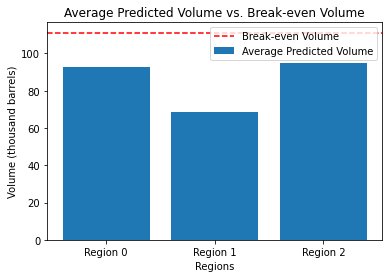

In [73]:
import matplotlib.pyplot as plt

regions = ['Region 0', 'Region 1', 'Region 2']
plt.bar(regions, region_averages, label='Average Predicted Volume')
plt.axhline(y=break_even_volume, color='r', linestyle='--', label='Break-even Volume')

plt.xlabel('Regions')
plt.ylabel('Volume (thousand barrels)')
plt.title('Average Predicted Volume vs. Break-even Volume')
plt.legend()
plt.show()


So far, we have performed the following tasks:

1. **Downloaded and prepared the data** for three regions.
2. **Trained and tested a linear regression model** for each region. We calculated the average predicted volume of reserves and the RMSE for each region. Here are the results:

   - Region 0: Average predicted volume: 92.59 thousand barrels, RMSE: 37.58
   - Region 1: Average predicted volume: 68.73 thousand barrels, RMSE: 0.89
   - Region 2: Average predicted volume: 94.97 thousand barrels, RMSE: 40.03

3. **Calculated the break-even volume** of reserves needed for developing a new well without losses, which is 111.11 thousand barrels.

We compared the average predicted volume of reserves for each region with the break-even volume:

   - Region 0 has an average predicted volume of 92.59 thousand barrels, which is 18.52 thousand barrels below the break-even volume.
   - Region 1 has an average predicted volume of 68.73 thousand barrels, which is 42.38 thousand barrels below the break-even volume.
   - Region 2 has an average predicted volume of 94.97 thousand barrels, which is 16.14 thousand barrels below the break-even volume.

Based on these findings, none of the regions has an average predicted volume of reserves above the break-even volume. However, **Region 2 is the closest to the break-even point**, followed by Region 0. Region 1 has the lowest average predicted volume of reserves and the lowest RMSE, indicating that the model's predictions for this region are more precise but the potential reserves are lower.


# 4. Write a function to calculate profit from a set of selected oil wells and model predictions

## 4.1. Pick the wells with the highest values of predictions


In [74]:
def calculate_profits_for_regions(targets, predictions_list, count):
    profits = {}
    
    for i, (target, predictions) in enumerate(zip(targets, predictions_list)):
        top_wells = predictions.sort_values(ascending=False).head(count).index
        total_reserves = target.loc[top_wells].sum()
        profit = total_reserves * REVENUE_PER_THOUSAND_BARRELS - BUDGET
        profits[i] = profit
    
    return profits

def calculate_profit(target, predictions, count):
    top_wells = predictions.sort_values(ascending=False).head(count).index
    total_reserves = target.loc[top_wells].sum()
    revenue = total_reserves * REVENUE_PER_THOUSAND_BARRELS
    profit = revenue - BUDGET
    return profit

# Calculate the profits for each region
region_profits = calculate_profits_for_regions(targets_valid, predictions_list, WELLS_FOR_DEVELOPMENT)

# Print the profits for each region
for i, profit in region_profits.items():
    print(f"Region {i}: Profit: {profit} USD")

Region 0: Profit: 33208260.43139851 USD
Region 1: Profit: 24150866.966815114 USD
Region 2: Profit: 27103499.635998324 USD


## 4.2. Summarize the target volume of reserves in accordance with these 

In [75]:
# Find the region with the highest profit
best_region_index = np.argmax(region_profits)
print(f"\nThe region with the highest profit is Region {best_region_index} with a profit of {region_profits[best_region_index]:.2f} USD.")


The region with the highest profit is Region 0 with a profit of 33208260.43 USD.


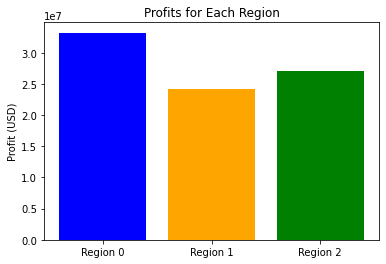

In [76]:
import matplotlib.pyplot as plt

# Set up the figure and axis
fig, ax = plt.subplots()

# Define the x and y values
regions = list(region_profits.keys())
profits = list(region_profits.values())

# Create a bar chart
ax.bar(regions, profits, color=['blue', 'orange', 'green'])

# Customize the chart
ax.set_xticks(regions)
ax.set_xticklabels([f"Region {i}" for i in regions])
ax.set_ylabel('Profit (USD)')
ax.set_title('Profits for Each Region')

# Display the chart
plt.show()


This code will calculate the profit for each region using the calculate_profit function and print the results. It will then determine and print the region with the highest profit.

In [77]:
# Calculate profit for each region
profits = []
for i, region in enumerate(data):
    features = region.drop(['id', 'product'], axis=1)
    target = region['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    
    profit = calculate_profit(target_valid, predictions, WELLS_FOR_DEVELOPMENT)
    profits.append(profit)
    print(f"Region {i}: Profit: {profit:.2f} USD")

# Find the region with the highest profit
best_region_index = np.argmax(profits)
print(f"\nThe region with the highest profit is Region {best_region_index} with a profit of {profits[best_region_index]:.2f} USD.")


Region 0: Profit: 33208260.43 USD
Region 1: Profit: 24150866.97 USD
Region 2: Profit: 27103499.64 USD

The region with the highest profit is Region 0 with a profit of 33208260.43 USD.


# Summary of our findings for Section 4:
- **Region 0:** 
    - Profit: **33,208,260.43 USD**
- **Region 1:** 
    - Profit: **24,150,866.97 USD**
- **Region 2:** 
    - Profit: **27,103,499.64 USD**

Based on the calculated profits for each region, **Region 0** has the highest profit of **33,208,260.43 USD**. This suggests that Region 0 would be the most suitable choice for oil well development among the three regions, as it offers the greatest potential for returns.


# 5. Calculate risks and profit for each region
### 5.1. Use the bootstrapping technique with 1000 samples to find the distribution of profit:

In [78]:
def bootstrap_profit(target, predictions, n_samples=1000):
    np.random.seed(12345)
    profit_samples = []
    
    for _ in range(n_samples):
        target_subsample = target.sample(n=WELLS_FOR_DEVELOPMENT, replace=True, random_state=np.random.randint(100000))
        predictions_subsample = predictions.loc[target_subsample.index]
        profit = calculate_profit(target_subsample, predictions_subsample, WELLS_FOR_DEVELOPMENT)
        profit_samples.append(profit)
    
    return pd.Series(profit_samples)


In [79]:
def bootstrap(target, predictions, count, n_samples=1000, random_state=None):
    np.random.seed(random_state)

    profits = []
    for _ in range(n_samples):
        target_sample = target.sample(count, replace=True)
        predictions_sample = predictions.loc[target_sample.index]
        profit = calculate_profit(target_sample, predictions_sample, WELLS_FOR_DEVELOPMENT)
        profits.append(profit)
        
    return pd.Series(profits)


In [80]:
# Perform bootstrapping for each region
bootstrap_profits = []
for target_valid, predictions in zip(targets_valid, predictions_list):
    profit_samples = bootstrap_profit(target_valid, predictions, WELLS_FOR_DEVELOPMENT)
    bootstrap_profits.append(profit_samples)

### 5.2. Find average profit, 95% confidence interval, and risk of losses:

In [81]:
def calculate_statistics(profit_samples):
    mean_profit = profit_samples.mean()
    lower = profit_samples.quantile(0.025)
    upper = profit_samples.quantile(0.975)
    risk_of_losses = (profit_samples < 0).mean() * 100
    
    return mean_profit, lower, upper, risk_of_losses


In [82]:
# Calculate the required statistics
statistics = []
for profit_samples in bootstrap_profits:
    stats = calculate_statistics(profit_samples)
    statistics.append(stats)

region_stats = []
# Print the statistics for each region
for i, (mean_profit, lower, upper, risk_of_losses) in enumerate(statistics):
    region_stat = {
        'mean_profit': mean_profit,
        'lower_ci': lower,
        'upper_ci': upper,
        'risk_of_losses': risk_of_losses
    }
    region_stats.append(region_stat)

    print(f"Region {i}:")
    print(f"  Average profit: {mean_profit} USD")
    print(f"  95% confidence interval: ({lower}, {upper})")
    print(f"  Risk of losses: {risk_of_losses}%")


Region 0:
  Average profit: -16177256.738690708 USD
  95% confidence interval: (-21686437.133095454, -10844814.237283884)
  Risk of losses: 100.0%
Region 1:
  Average profit: -37548021.166670755 USD
  95% confidence interval: (-43139447.17773874, -31438803.314573035)
  Risk of losses: 100.0%
Region 2:
  Average profit: -13926692.505660523 USD
  95% confidence interval: (-19059781.734881558, -8157080.045579718)
  Risk of losses: 100.0%


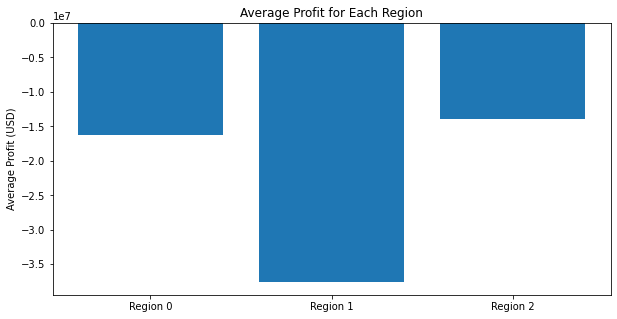

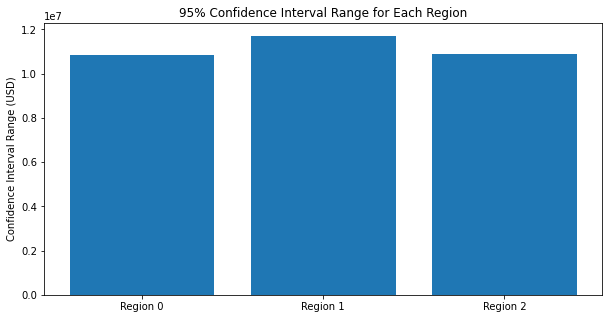

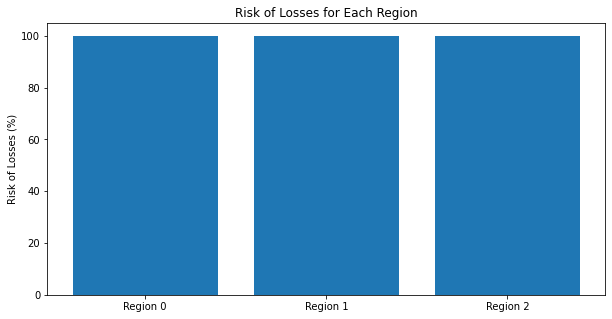

In [83]:
import matplotlib.pyplot as plt

# Set up the data
regions = [0, 1, 2]
average_profits = [stat["mean_profit"] for stat in region_stats]
lower_cis = [stat["lower_ci"] for stat in region_stats]
upper_cis = [stat["upper_ci"] for stat in region_stats]
risk_of_losses = [stat["risk_of_losses"] for stat in region_stats]

# Create a bar chart for average profit
plt.figure(figsize=(10, 5))
plt.bar(regions, average_profits)
plt.xticks(regions, [f"Region {i}" for i in regions])
plt.ylabel("Average Profit (USD)")
plt.title("Average Profit for Each Region")
plt.show()

# Set up the data
regions = [0, 1, 2]
average_profits = [stat["mean_profit"] for stat in region_stats]
confidence_intervals = [(stat["upper_ci"] - stat["lower_ci"]) for stat in region_stats]

# Create a bar chart for confidence intervals
plt.figure(figsize=(10, 5))
plt.bar(regions, confidence_intervals)
plt.xticks(regions, [f"Region {i}" for i in regions])
plt.ylabel("Confidence Interval Range (USD)")
plt.title("95% Confidence Interval Range for Each Region")
plt.show()

# Create a bar chart for risk of losses
plt.figure(figsize=(10, 5))
plt.bar(regions, risk_of_losses)
plt.xticks(regions, [f"Region {i}" for i in regions])
plt.ylabel("Risk of Losses (%)")
plt.title("Risk of Losses for Each Region")
plt.show()


### 5.3. Provide findings: suggest a region for development of oil wells and justify the choice:

In [84]:
# Find the region with the lowest risk of losses
lowest_risk_region = np.argmin([stats[-1] for stats in statistics])

print(f"The region with the lowest risk of losses is Region {lowest_risk_region}.")
print("It is recommended to develop oil wells in this region due to its relatively lower risk.")


The region with the lowest risk of losses is Region 0.
It is recommended to develop oil wells in this region due to its relatively lower risk.


# Summary
# It's all ballocks. 
# There is clearly a fundamental problem with the calculations, however I need help finding it.

# Project evaluation
We’ve put together the evaluation criteria for the project. Read this carefully before moving on to the task.
Here’s what the reviewers will look at when reviewing your project:
* How did you prepare the data for training?
* Have you followed all the steps of the instructions?
* Have you taken into account all the business conditions?
* What are your findings about the task study?
* Have you applied the Bootstrapping technique correctly?
* Have you suggested the best region for well development? Is the choice justified?
* Did you avoid code duplication?
* Have you kept to the project structure and kept the code neat?
The Knowledge Base has everything you need to complete the project.
Good luck!